# DEMO accessing well log data from OpendTect

- Easily retrieve (well log) data from OpendTect

- Do things with it

- Export data for easy load back into OpendTect



### License, acknowledgement and disclaimer
Created by I^3 GEO in collaboration with dGB Earth Sciences.

Licensed under under Creative Commmons BY-SA 3.0: https://creativecommons.org/licenses/by-sa/3.0/

The notebook as shown was developed for a specific project containing the New Zealand Maui data.  Some coding items, e.g. the log selections and alias dictionaries, should be adjusted for the OpendTect project that is active and connected to.
The geoscience examples are for demo purposes only, and should not be used verbatim for real projects.

### Preliminaries

Importing some standard modules and setting some settings.

In [ ]:
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sys.path.append('D:\\Applications\\6.6.0\\bin\\python\\')

### odpy 

Use the odpy and specifically the odpy.wellman module to extract data from OpendTect, these modules are shipped with OpendTect.

In [ ]:
import odpy.wellman as wm
wm

In [ ]:
well_names = wm.getNames(reload=True) # get database information of OpendTect about all wells in the project
well_names

In [ ]:
all_well_tracks = {}
for name in well_names:
    all_well_tracks[name] = wm.getTrack(name)
    print(name, all_well_tracks[name])

### note:

All tracks are vertical. Reorganize the data a bit so surface coordinates and TD later can easily be accessed later.

In [ ]:
all_well_tracks_r = {}
for name in well_names:
    meta = {}
    meta['surface_coordinates'] = np.asarray([all_well_tracks[name][2][0], all_well_tracks[name][3][0]])
    meta['TD'] = all_well_tracks[name][0][-1]
    all_well_tracks_r[name] = meta
all_well_tracks_r 

### Retrieving well logs and reorganizing them in dictionairy of pandas dataframes

In [ ]:
all_log_headers = {}
for name in well_names:
    all_log_headers[name] = wm.getLogNames(name)
    print(name, all_log_headers[name])

In [ ]:
#for each well, read density, sonic, gamma ray, deep induction and spontaneous potential
aliases_l = {
    'RHOB': ['RHOB', 'Borehole corrected density log'],
    'DT' : ['DT', 'SONIC', 'DTC'],
    'GR' : ['GR', 'GRXS', 'ECGR', 'GRXB'],
    'ILD' : ['ILD', 'LLD', 'Borehole corrected LLD'],
    'SP' : ['SP']
}

all_logs = {}
all_logs_not_found = {}
for well_name in well_names:
    logs_not_found = []
    logs = {}
    for log_type in aliases_l:
        log_found = 0
        for alias in aliases_l[log_type]:
            if alias in all_log_headers[well_name]:
                logs[log_type] = wm.getLog(well_name, alias)
                log_found = 1
                break
        if(log_found == 0): logs_not_found.append(log_type)
    all_logs[well_name] = logs
    all_logs_not_found[well_name] = logs_not_found

all_logs_not_found

In [ ]:
depth_index = np.arange(0, 4000, 0.1524)
all_logs_p = {}
for well_name in well_names:
    logs = np.empty((depth_index.size, 0))
    header = []
    for log in all_logs[well_name]:
        header.append(log)
        d = np.asarray(all_logs[well_name][log][0])
        l = np.asarray(all_logs[well_name][log][1])
        l_resampled = np.expand_dims(np.interp(depth_index, d, l, left = 1e30, right = 1e30), axis=1)
        logs = np.concatenate((logs, l_resampled), axis=1)
        all_logs_p[well_name]= pd.DataFrame(data=logs, index=depth_index, columns=header)
all_logs_p['Maui-5']

In [ ]:
defined = all_logs_p['Maui-5']['RHOB'] <1e10
all_logs_p['Maui-5']['RHOB'][defined].plot()

### Retrieve well markers and isolate interval of interest

The well markers are reorganized into a dictionairy format for later convinience.

In [ ]:
all_markers = {}
for name in well_names:
    t = wm.getMarkers(name)[0:2] #color codes are not needed
    all_markers[name] = {marker: md for marker, md in zip(t[0], t[1])} # convert to dictionairy
    print(name, all_markers[name])

## Net/Gross example

## Kapuni Group

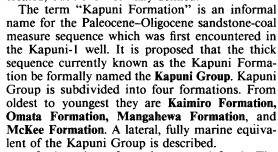

In [ ]:
aliases_m = ['Kapuni Gr']
formation_not_present = []
zoi_all =  {}
for name in well_names:
    marker_found = 0
    for alias in aliases_m:
        if alias in all_markers[name]:
            zoi = {'upper': all_markers[name][alias]}
            marker_found = 1
            #do something clever to find unknown next key, if present
            t = list(all_markers[name])
            t_index = t.index(alias)
            if t_index + 1 < len(t): #if True there is (at least) one well marker below, otherwise use well TD
                next_key = t[t_index + 1]
                zoi['lower'] = all_markers[name][next_key]
            else:
                zoi['lower'] = all_well_tracks_r[name]['TD']
            zoi_all[name] = zoi
            print (name, zoi)
            break
    if marker_found == 0: formation_not_present.append(name)
print(formation_not_present)

In [ ]:
#net cut-offs
rhob_high = 2.407 # ~0.15 porosity
rhob_low = 2.083 # ~0.35 porosity to screen for coals and outliers
gr_high = 45

reservoir_all = {}
for name in zoi_all:
    t = all_logs_p[name].loc[zoi_all[name]['upper']:zoi_all[name]['lower'], ['RHOB', 'GR']]
    t['reservoir'] = np.where((t['RHOB'] < rhob_high) & (t['RHOB'] > rhob_low) & (t['GR'] > gr_high),1,0)
    net = t['reservoir'].sum() * 0.3048 * 0.5
    gross = zoi_all[name]['lower'] - zoi_all[name]['upper']
    ng = net/gross
    reservoir_all[name] = np.asarray([gross, net, ng])
reservoir_all

### Plot the result in a scatter plot

Point size is total net.
Color represents N/G ratio.


Reimport in OpendTect as image to use on the base map.

In [ ]:
x = [all_well_tracks_r[name]['surface_coordinates'][0] for name in reservoir_all]
y = [all_well_tracks_r[name]['surface_coordinates'][1] for name in reservoir_all]
s = [reservoir_all[name][1] for name in reservoir_all]
c = [reservoir_all[name][2] for name in reservoir_all]
sp = 5*np.asarray(s) # rescale for plot

fig=plt.figure(figsize=[12, 12])
ax = plt.Axes(fig, [0., 0., 1., 1.])
#remove any borders for the saved image, the corner points of the plot must be the corner points of the image
ax.set_axis_off() 
fig.add_axes(ax)
plt.xlim([1620000, 1655000])
plt.ylim([5595000, 5630000])
plt.scatter(x, y, s=sp, c=c, cmap='copper' ) #x is easting
plt.savefig('D:\\tmp_odt_demo\\net_sand_map.png', bbox_inches='tight')
#apply some editing for viewing
ax.set_axis_on()
ax = plt.Axes(fig, [0.1, 0.1, 0.9, 0.9])
plt.colorbar()

## save data as pseudo-las for loading as 'well log'

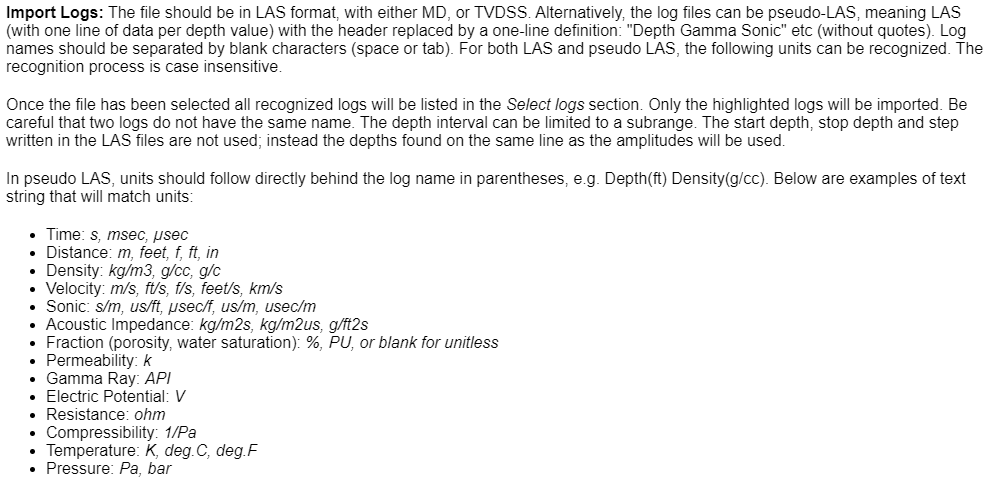

In [ ]:
header = 'Depth(m)   NG()'
folder = 'D:\\tmp_odt_demo\\'
smoothing_lenght = 25
box = (1 / smoothing_lenght) * np.ones(smoothing_lenght)
for name in zoi_all:
    d = np.arange(zoi_all[name]['upper'], zoi_all[name]['lower'], 0.1524)
    ng = reservoir_all[name][2]
    ng = ng * np.convolve(np.ones_like(d), box, mode='same') #taper for viewing in OdT
    pl = np.stack((d, ng), axis=1)
    filename = folder + 'ng_' + name + '.dat'
    np.savetxt(filename, pl, fmt='%.5e', header=header, comments='')

## PCA Example

PCA is a method to reoriented the coordinate system such that each next direction captures most of the remain data variance.

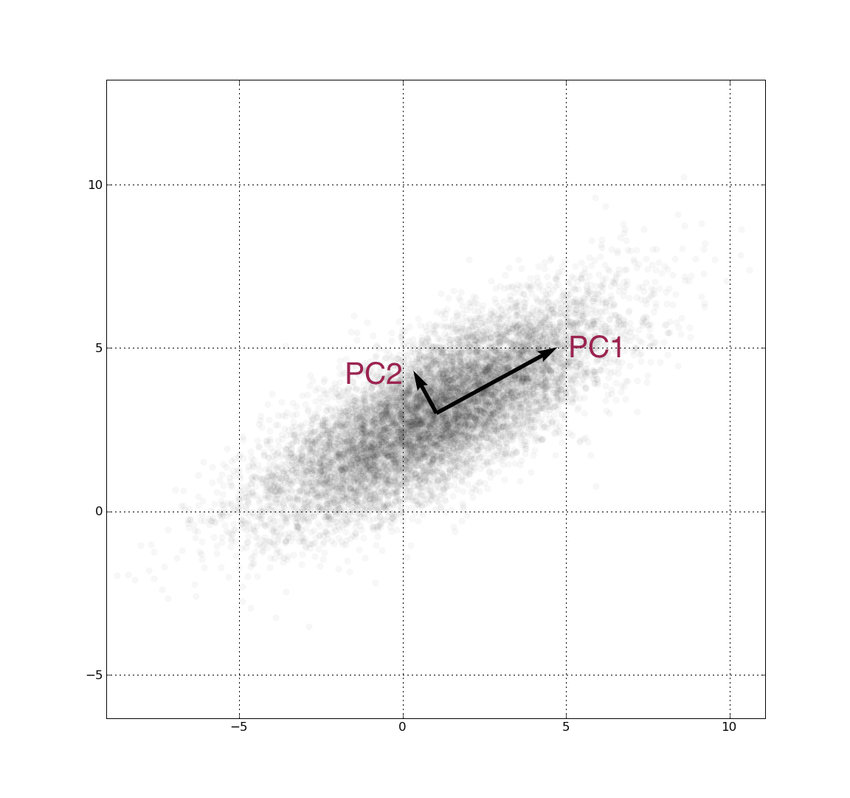
By Nicoguaro - Own work, CC BY 4.0, https://commons.wikimedia.org/w/index.php?curid=46871195

In [ ]:
include_key = ['DT']
exclude_key = 'SP'
headers =  list(aliases_l.keys())
headers.remove(exclude_key)
use_well_names = [name for name in all_logs_not_found if all_logs_not_found[name] != include_key]
wells_with_log_and_marker = zoi_all.keys() & use_well_names
wells_with_log_and_marker

In [ ]:
all_logdata_in_zone = pd.DataFrame(columns=headers)
for name in wells_with_log_and_marker:
    t = all_logs_p[name].loc[zoi_all[name]['upper']:zoi_all[name]['lower'], headers]
    all_logdata_in_zone = all_logdata_in_zone.append(t)

In [ ]:
non_undef =  all_logdata_in_zone[(all_logdata_in_zone.iloc[:, :] < 1e10).all(axis=1)]
x =  non_undef.values
x[:,3] =  np.log(x[:,3])
scaler = StandardScaler()
x = scaler.fit_transform(x)
#plt.plot(x[:,0])

In [ ]:
pca = PCA(n_components=4)
principle_components = pca.fit_transform(x)
pca.explained_variance_ratio_

In [ ]:
kmeans = KMeans(n_clusters = 6)
c = kmeans.fit_predict(principle_components[:,0:2])
kmeans.cluster_centers_

In [ ]:
from scipy.spatial import Voronoi ,voronoi_plot_2d 
vor = Voronoi(kmeans.cluster_centers_)
voronoi_plot_2d(vor, line_colors='w') 
catch = plt.hist2d(principle_components[:,0], principle_components[:,1], range= [[-2,4], [-3,2]], bins=50)
plt.colorbar()
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], c='w', s=500, marker='x', linewidths=5)
fig = plt.gcf()
fig.set_size_inches(16, 12)

In [ ]:
non_undef['class'] =  c
import seaborn as sns
# sns.displot(data=non_undef, x='class')
# sns.displot(data=non_undef, x='GR', hue='class', kind="kde", aspect=3, multiple="fill", palette='ch:rot=-.25,hue=1,light=.75')
# sns.displot(data=non_undef, x='RHOB', hue='class', kind="kde", aspect=3, multiple="fill", palette='ch:rot=-.25,hue=1,light=.75')
pg = sns.jointplot(data=non_undef, x='RHOB', y='GR', hue='class', kind='kde', height=10, palette='tab10', thresh=0.3, xlim=(1.8, 2.8), ylim=(25, 125))


In [ ]:
#for name in wells_with_log_and_marker:
header = 'Depth(m)   PC1()   PC2()   PC3()   PC4()   cluster()'
folder = 'D:\\tmp_odt_demo\\'

for name in wells_with_log_and_marker: 
    xw = all_logs_p[name].loc[zoi_all[name]['upper']:zoi_all[name]['lower'], headers].values
    dw =  np.expand_dims(all_logs_p[name].loc[zoi_all[name]['upper']:zoi_all[name]['lower']].index.values, axis=1)
    xw[:,3] =  np.log(xw[:,3])
    xw = scaler.transform(xw)
    xp =  pca.transform(xw)
    cluster = np.expand_dims(kmeans.predict(xp[:,:2]), axis=1)
    xo = np.hstack((dw, xp, cluster))

    filename = folder + 'pca_cluster_' + name + '.dat'
    np.savetxt(filename, xo, fmt=['%.3f','%.3e','%.3e','%.3e','%.3e','%i'], header=header, comments='')   